In [1]:
#This is for analyzing HCP thickness data 063025 DJ
# use niwrap3912 for the kernel
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
import yaspy
import scipy
import pyvista as pv
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels

pv.start_xvfb()
atlas_path = '/Users/dennis.jungchildmind.org/Downloads/Schaefer2018_100Parcels_7Networks_order.dlabel.nii'
num_parcels = int(atlas_path.split('_')[1].split('Parcels')[0])  # Extract number of parcels from atlas path
print(num_parcels)

normalize_data = False #zscore

/opt/anaconda3/envs/niwrap3912/lib/python3.11/site-packages/pyvista/plotting/utilities/xvfb.py:48: PyVistaDeprecationWarning: This function is deprecated and will be removed in future version of PyVista. Use vtk-osmesa instead.
  warnings.warn(


100


In [2]:
#get Yeo Networks from the label data
yeo_networks = nib.load(atlas_path).header.get_axis(0)

yeo_network_data = yeo_networks.get_element(0)[1]
print(yeo_network_data)

#each yeo_network_data[key] has ('17Networks_LH_VisCent_ExStr_1',...), save the third string after string split by '_'
yeo_network_names = []
yeo_network_colors = []
for i,key in enumerate(yeo_network_data):
    if i == 0:
        yeo_network_names.append(np.nan)
        yeo_network_colors.append((0,0,0,0))
        continue#skip the first key
   # print(yeo_network_data[key][0])#network name
    network_parts = yeo_network_data[key][0].split('_')
    #print(network_parts)
    yeo_network_names.append(network_parts[2])  # Append the network name (VisCent)
    yeo_network_colors.append(yeo_network_data[key][1])

print(yeo_network_names)

print(yeo_network_colors)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


{0: ('???', (1.0, 1.0, 1.0, 0.0)), 1: ('7Networks_LH_Vis_1', (0.470588, 0.0705882, 0.513726, 1.0)), 2: ('7Networks_LH_Vis_2', (0.470588, 0.0705882, 0.517647, 1.0)), 3: ('7Networks_LH_Vis_3', (0.470588, 0.0705882, 0.521569, 1.0)), 4: ('7Networks_LH_Vis_4', (0.470588, 0.0705882, 0.529412, 1.0)), 5: ('7Networks_LH_Vis_5', (0.470588, 0.0705882, 0.533333, 1.0)), 6: ('7Networks_LH_Vis_6', (0.470588, 0.0705882, 0.537255, 1.0)), 7: ('7Networks_LH_Vis_7', (0.470588, 0.0705882, 0.541176, 1.0)), 8: ('7Networks_LH_Vis_8', (0.470588, 0.0705882, 0.545098, 1.0)), 9: ('7Networks_LH_Vis_9', (0.470588, 0.0705882, 0.54902, 1.0)), 10: ('7Networks_LH_SomMot_1', (0.27451, 0.509804, 0.701961, 1.0)), 11: ('7Networks_LH_SomMot_2', (0.27451, 0.509804, 0.709804, 1.0)), 12: ('7Networks_LH_SomMot_3', (0.27451, 0.509804, 0.713726, 1.0)), 13: ('7Networks_LH_SomMot_4', (0.27451, 0.509804, 0.717647, 1.0)), 14: ('7Networks_LH_SomMot_5', (0.27451, 0.509804, 0.721569, 1.0)), 15: ('7Networks_LH_SomMot_6', (0.27451, 0.5098

In [3]:
#smoothing param
#smoo_param = '6mm_fwhm_'#if smoothing param applied 
smoo_param = '6mm_fwhm_'
#reselect random N subjects from lh_thickness_all and rh_thickness_all
N = 300
#set seed for np.random.choice
#np.random.seed(0)

In [4]:
from sklearn.covariance import LedoitWolf

def improved_partial_correlation_with_shrinkage(x):
    """
    Partial correlation with Ledoit-Wolf shrinkage applied consistently
    x: (n_features, n_samples) 
    Returns: (n_features, n_features) partial correlation matrix
    """
    from sklearn.covariance import LedoitWolf
    
    n_features, n_samples = x.shape
    
    # Step 1: Handle NaN values
    x_clean = x.copy()
    for i in range(n_features):
        mask = np.isnan(x_clean[i, :])
        if mask.any():
            x_clean[i, mask] = np.nanmean(x_clean[i, :])
    
    # Step 2: Calculate mean across features for each sample
    x_mean = np.mean(x_clean, axis=0)  # Shape: (n_samples,)
    
    # Step 3: Create augmented data matrix
    # Transpose for sklearn: samples x features
    augmented_data = np.column_stack([x_clean.T, x_mean])  # Shape: (n_samples, n_features+1)
    
    # Step 4: Apply Ledoit-Wolf shrinkage
    lw = LedoitWolf()
    shrunk_cov = lw.fit(augmented_data).covariance_  # Shape: (n_features+1, n_features+1)
    
    # Convert to correlation matrix
    def cov_to_corr(cov):
        std = np.sqrt(np.diag(cov))
        return cov / np.outer(std, std)
    
    shrunk_corr = cov_to_corr(shrunk_cov)  # Shape: (n_features+1, n_features+1)
    
    # Step 5: Extract components for partial correlation
    r_ij = shrunk_corr[:n_features, :n_features]  # Shape: (n_features, n_features)
    r_ic = shrunk_corr[:n_features, -1]           # Shape: (n_features,)
    
    # Step 6: Calculate partial correlations
    r_icjc = np.outer(r_ic, r_ic)  # Shape: (n_features, n_features)
    denominator = np.sqrt(np.outer((1 - r_ic**2), (1 - r_ic**2)))  # Shape: (n_features, n_features)
    
    # Avoid division by zero
    denominator[denominator < np.finfo(float).eps] = np.finfo(float).eps
    
    partial_corr = (r_ij - r_icjc) / denominator  # Shape: (n_features, n_features)
    
    # Step 7: Clean up the matrix
    np.fill_diagonal(partial_corr, 0)
    partial_corr[np.isnan(partial_corr) | np.isinf(partial_corr)] = 0
    partial_corr = np.clip(partial_corr, -1, 1)
    
    return partial_corr  # Shape: (n_features, n_features)

def calculate_partial_correlations(x):
    """
    Calculate partial correlations between regions while controlling for mean thickness.
    
    Parameters:
    -----------
    x : numpy.ndarray
        Input data matrix with shape (n_regions, n_samples)
        
    Returns:
    --------
    partial_corr : numpy.ndarray
        Matrix of partial correlations between regions
    """
    # First get pairwise correlations between regions
    x = x - np.nanmean(x, axis=0)
    r_ij = np.corrcoef(x)
    # Calculate mean thickness across regions
    x_mean = np.nanmean(x, axis=0)
    # Get correlations between each region and the mean
    r_ic = np.corrcoef(x, x_mean[np.newaxis,:])[-1,:-1]
    
    # Calculate partial correlations controlling for mean
    # Formula: (r_ij - r_i,m * r_j,m) / sqrt((1-r_i,m^2)(1-r_j,m^2))
    # where r_i,m is correlation of region i with mean
    r_icjc = np.outer(r_ic, r_ic)
    partial_corr = (r_ij - r_icjc) / np.sqrt(np.outer((1-r_ic**2), (1-r_ic**2)))


    # zero out correlations of 1 (to avoid division by 0)
    partial_corr[np.isclose(partial_corr, 1)] = 0
    # Fisher z-transform the correlations
    #partial_corr = 0.5 * np.log((1 + partial_corr) / (1 - partial_corr))

    # Clean up any invalid values
    partial_corr[np.isnan(partial_corr) | np.isinf(partial_corr)] = 0
    

 
    return partial_corr

def plot_subject_similarity(hemisphere_data, radii, transpose=False, partial_corr=False):
    """
    Plot similarity matrices between subjects for different thickness measures and radii.
    
    Args:
        hemisphere_data (dict): Dictionary containing thickness data for one hemisphere
        radii (list): List of radius values used for smoothing
    """
    total_corr = {}
    wm2inf_corr = {}
    inf2pial_corr = {}
    plt.figure(figsize=(20, 12))
    for i,radius in enumerate(radii):
        # Total thickness
        plt.subplot(3, len(radii), i+1)
        if transpose:
            if partial_corr:
                subj_corr = calculate_partial_correlations(hemisphere_data['total'][i].T)
            else:
                subj_corr = np.corrcoef(hemisphere_data['total'][i].T)
        else:
            if partial_corr:
                subj_corr = calculate_partial_correlations(hemisphere_data['total'][i])
            else:
                subj_corr = np.corrcoef(hemisphere_data['total'][i])
        total_corr[i] = subj_corr.copy()
        #remove diagonal   
        subj_corr[np.eye(subj_corr.shape[0], dtype=bool)] = np.nan
        im = plt.imshow(subj_corr, cmap='bwr')
        plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.title(f'Total Thickness\nRadius {radius}mm')
        plt.xlabel('Subject')
        plt.ylabel('Subject')
        
        # WM to Inf thickness
        plt.subplot(3, len(radii), i+1+len(radii))
        if transpose:
            if partial_corr:
                subj_corr = calculate_partial_correlations(hemisphere_data['wm2inf'][i].T)
            else:
                subj_corr = np.corrcoef(hemisphere_data['wm2inf'][i].T)
        else:
            if partial_corr:
                subj_corr = calculate_partial_correlations(hemisphere_data['wm2inf'][i])
            else:
                subj_corr = np.corrcoef(hemisphere_data['wm2inf'][i])
        wm2inf_corr[i] = subj_corr.copy()
        subj_corr[np.eye(subj_corr.shape[0], dtype=bool)] = np.nan
        im = plt.imshow(subj_corr, cmap='bwr')
        plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.title(f'WM to Inf Thickness\nRadius {radius}mm')
        plt.xlabel('Subject')
        plt.ylabel('Subject')
        
        # Inf to Pial thickness
        plt.subplot(3, len(radii), i+1+2*len(radii))
        if transpose:
            if partial_corr:
                subj_corr = calculate_partial_correlations(hemisphere_data['inf2pial'][i].T)
            else:
                subj_corr = np.corrcoef(hemisphere_data['inf2pial'][i].T)
        else:
            if partial_corr:
                subj_corr = calculate_partial_correlations(hemisphere_data['inf2pial'][i])
            else:
                subj_corr = np.corrcoef(hemisphere_data['inf2pial'][i])
        inf2pial_corr[i] = subj_corr.copy()
        subj_corr[np.eye(subj_corr.shape[0], dtype=bool)] = np.nan
        im = plt.imshow(subj_corr, cmap='bwr')
        plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.title(f'Inf to Pial Thickness\nRadius {radius}mm')
        plt.xlabel('Subject')
        plt.ylabel('Subject')
    plt.tight_layout()
    
    return total_corr, wm2inf_corr, inf2pial_corr

def parcellate_data(matrix, atlas_path, hemisphere):
    """Parcellate cortical layer data using a given atlas."""
    # Load atlas
    parcelIndices = nib.load(atlas_path).get_fdata()[0]
    max_parcel_ind = int(np.max(parcelIndices))
    print(max_parcel_ind)
    # Split indices by hemisphere
    if hemisphere == 'lh':
        parcelIndices = parcelIndices[0:32492]
    elif hemisphere == 'rh':
        parcelIndices = parcelIndices[32492:]


    # Initialize output array
    parcellated = []
    
    # Parcellate data for each subject
    for subject_idx in range(matrix.shape[0]):
        m = int(max_parcel_ind/2)+1
     
        # Initialize array for this hemisphere's parcels
        subject_data = np.zeros(m)
        
        # Get subject's data
        data = matrix[subject_idx]
        
        # Set parcel range based on hemisphere
        if hemisphere == 'lh':
            parcel_range = range(1, m)
        elif hemisphere == 'rh':
            parcel_range = range(m, max_parcel_ind+1)
            
        # Calculate mean for each parcel
        for k in parcel_range:
            mask = parcelIndices == k
            if np.sum(mask) > 0:
                # Use trimmed mean with 10% trim on both ends
                # Science advances paper, "structural covariance, Parcellation Approach in Methods"
                parcel_idx = k if hemisphere == 'lh' else k-m+1
                
                subject_data[parcel_idx] = scipy.stats.trim_mean(data[mask][~np.isnan(data[mask])], proportiontocut=0.1)
                    
        # Append subject's parcellated data
        parcellated.append(subject_data)
            
    # Convert list to numpy array
    return np.vstack(parcellated)


In [5]:
#for each subject dir check if both thickness file for left and right hemisphere exists
#store the subject dirs that have both thickness files in a list
#for hcp
baseDir_hcp = '/Users/dennis.jungchildmind.org/OneDrive - Child Mind Institute/hcp1200-thickness'
# Get all subdirectories in baseDir

subject_dirs_hcp = [d for d in os.listdir(baseDir_hcp) if os.path.isdir(os.path.join(baseDir_hcp, d))]

print(subject_dirs_hcp)



# Dictionary to store data for each subject
subject_data = {}
subject_dirs_with_thickness = []    
for subject in subject_dirs_hcp:
    lh_thickness_path = f'/Users/dennis.jungchildmind.org/OneDrive - Child Mind Institute/hcp1200-thickness/{subject}/{subject}.L.thickness.32k_{smoo_param}fs_LR.shape.gii'
    rh_thickness_path = f'/Users/dennis.jungchildmind.org/OneDrive - Child Mind Institute/hcp1200-thickness/{subject}/{subject}.R.thickness.32k_{smoo_param}fs_LR.shape.gii'
    if os.path.exists(lh_thickness_path) and os.path.exists(rh_thickness_path):
        subject_dirs_with_thickness.append(subject)
   
print(len(subject_dirs_with_thickness))


#store in a larger array    
lh_thickness_all = []
rh_thickness_all = []
for subject in subject_dirs_with_thickness:
    lh_thickness_path = f'/Users/dennis.jungchildmind.org/OneDrive - Child Mind Institute/hcp1200-thickness/{subject}/{subject}.L.thickness.32k_{smoo_param}fs_LR.shape.gii'
    rh_thickness_path = f'/Users/dennis.jungchildmind.org/OneDrive - Child Mind Institute/hcp1200-thickness/{subject}/{subject}.R.thickness.32k_{smoo_param}fs_LR.shape.gii'
    lh_thickness = nib.load(lh_thickness_path).darrays[0].data
    rh_thickness = nib.load(rh_thickness_path).darrays[0].data
    
    if normalize_data:
        lh_thickness = (lh_thickness - np.mean(lh_thickness)) / np.std(lh_thickness)
        rh_thickness = (rh_thickness - np.mean(rh_thickness)) / np.std(rh_thickness)
        
    lh_thickness_all.append(lh_thickness)
    rh_thickness_all.append(rh_thickness)

print(len(lh_thickness_all))
print(len(rh_thickness_all))

lh_thickness_all = np.array(lh_thickness_all)
rh_thickness_all = np.array(rh_thickness_all)


#
if lh_thickness_all.shape[0] == rh_thickness_all.shape[0]:
    #
    print('lh_thickness_all and rh_thickness_all have the same number of subjects')
    r_ind = np.random.choice(lh_thickness_all.shape[0], size=N, replace=False)
    lh_thickness_all = lh_thickness_all[r_ind]
    rh_thickness_all = rh_thickness_all[r_ind]
else:
    lh_thickness_all = lh_thickness_all[np.random.choice(lh_thickness_all.shape[0], size=N, replace=False)]
    rh_thickness_all = rh_thickness_all[np.random.choice(rh_thickness_all.shape[0], size=N, replace=False)]



['103414', '115320', '173132', '148941', '175035', '150524', '140319', '195041', '180533', '121719', '162228', '163331', '157336', '165032', '168947', '192237', '176845', '200210', '160123', '150928', '111716', '137229', '190132', '147737', '178748', '113619', '105115', '103818', '127226', '126931', '144125', '142828', '178142', '128632', '121921', '161630', '107422', '176441', '113821', '182032', '109325', '160729', '175237', '180937', '150726', '165638', '187547', '168341', '192035', '202113', '187345', '111514', '107220', '188751', '135124', '173738', '155231', '129129', '142424', '119126', '133827', '198350', '100206', '125525', '134728', '169747', '201414', '130720', '164636', '177645', '151728', '108121', '175540', '179346', '146937', '112819', '139233', '117930', '128127', '153025', '149741', '130114', '137936', '194645', '198249', '186141', '159340', '201818', '120515', '183034', '114318', '108323', '116221', '137532', '168038', '169545', '146331', '172938', '148436', '118528',

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


100


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


100
(50, 50)
(50, 50)


Text(0.5, 1.0, 'Right Hemisphere')

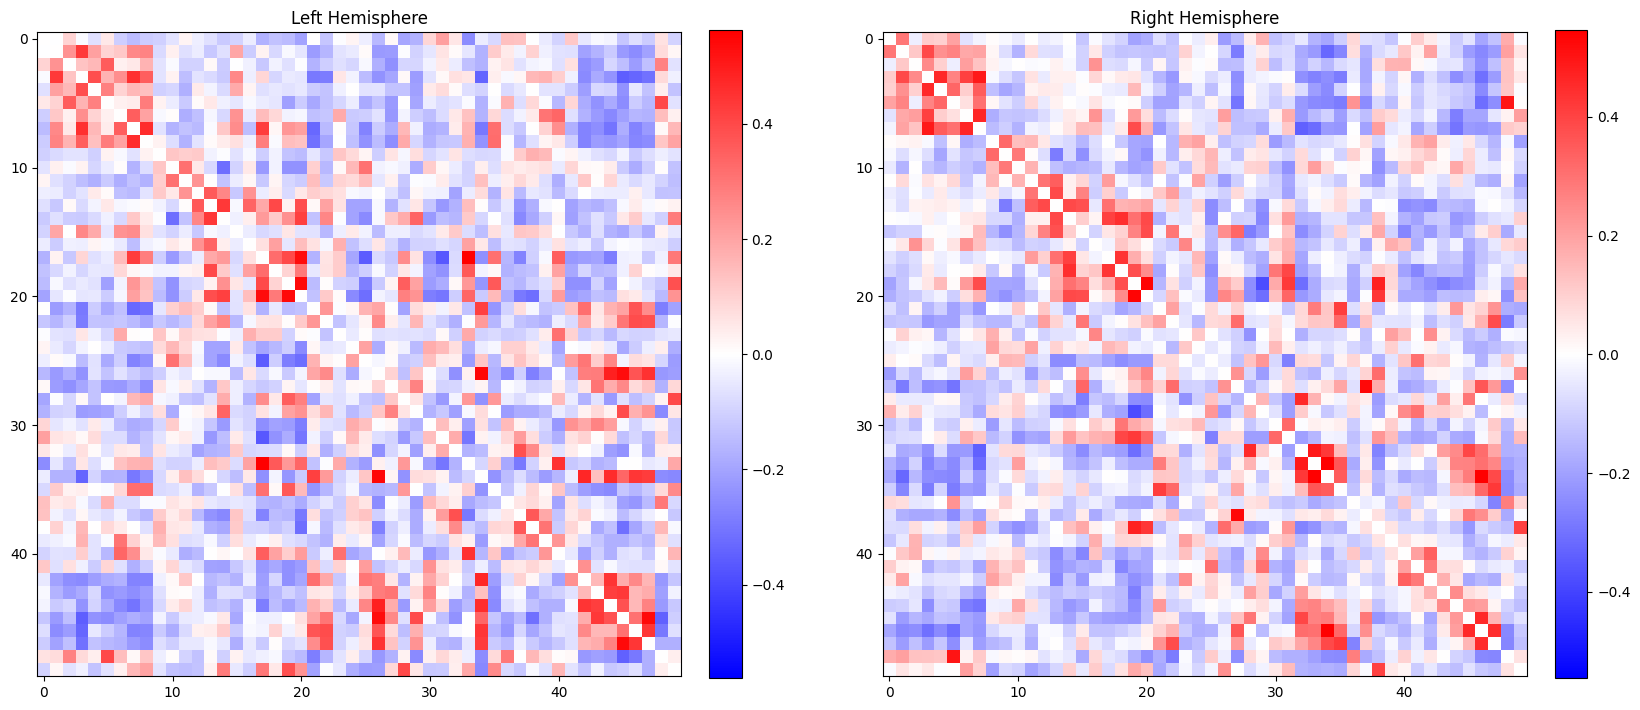

In [6]:


lh_hcp = parcellate_data(lh_thickness_all, atlas_path, 'lh').T
rh_hcp = parcellate_data(rh_thickness_all, atlas_path, 'rh').T


lh_hcp_partialcorr = calculate_partial_correlations(lh_hcp[1:])
rh_hcp_partialcorr = calculate_partial_correlations(rh_hcp[1:])
#lh_hcp_partialcorr= improved_partial_correlation_with_shrinkage(lh_hcp[1:])
#rh_hcp_partialcorr = improved_partial_correlation_with_shrinkage(rh_hcp[1:])

print(lh_hcp_partialcorr.shape)
print(rh_hcp_partialcorr.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

# Get max absolute value for symmetric color limits
vmax = max(abs(lh_hcp_partialcorr.max()), abs(lh_hcp_partialcorr.min()))
im1 = ax1.imshow(lh_hcp_partialcorr, cmap='bwr', vmin=-vmax, vmax=vmax)
cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
ax1.set_title('Left Hemisphere')

vmax = max(abs(rh_hcp_partialcorr.max()), abs(rh_hcp_partialcorr.min()))
im2 = ax2.imshow(rh_hcp_partialcorr, cmap='bwr', vmin=-vmax, vmax=vmax)
cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
ax2.set_title('Right Hemisphere')






#save the arrays

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


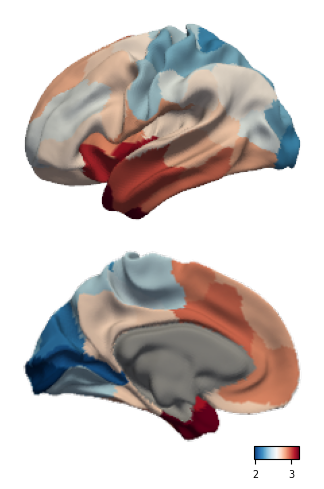

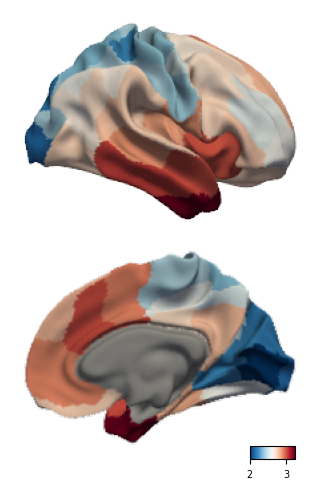

In [7]:
# Load atlas data
atlasDat = nib.load(atlas_path).get_fdata()[0].astype(int)

# Create gradient maps and plot for both hemispheres
for hemi, hcp_data, start_idx, end_idx, surf_file in [
    ('lh', lh_hcp_partialcorr, 0, 32492, 'S1200.L.white_MSMAll.32k_fs_LR.surf.gii'),
    ('rh', rh_hcp_partialcorr, 32492, None, 'S1200.R.white_MSMAll.32k_fs_LR.surf.gii')
]:
    # Create mask for non-zero atlas values
    mask = atlasDat[start_idx:end_idx] != 0

    # Create gradient maps

    grad = []
    for j in range(1):
        if hemi == 'lh':
            grad_values = np.mean(lh_hcp[1:],axis=-1)
            grad.append(map_to_labels(grad_values, atlasDat[start_idx:end_idx], mask=mask, fill=np.nan))
        else:
            grad_values = np.mean(rh_hcp[1:],axis=-1)
            grad.append(map_to_labels(grad_values, atlasDat[start_idx:end_idx], mask=mask, fill=np.nan))

    # Create plotters for first 3 gradients
    plotters = []
    for pc in range(1):
        plotter = yaspy.Plotter(
            f'/Users/dennis.jungchildmind.org/Downloads/HCP_S1200_Atlas_Z4_pkXDZ/{surf_file}',
            hemi=hemi,
        )
        overlay = plotter.overlay(grad[pc], cmap='RdBu_r', alpha=1)# vmin=1.5, vmax=3.5)
        plotter.border(grad[pc], alpha=0)
        plotters.append([plotter.screenshot("lateral"), plotter.screenshot("medial"), overlay])

    img = yaspy.montage(
        [[plotters[0][0]],
         [plotters[0][1]]],
        pad=10,
        shareh=True,
        sharew=True,  # Share width across subplots
    )
        
    # Create figure with controlled size
    f, ax = plt.subplots()
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.box(False)
    plt.tight_layout()

    cax = ax.inset_axes((0.8, 0, 0.15, 0.03))
    cbar = plt.colorbar(overlay, cax=cax, orientation="horizontal")
    cbar.ax.tick_params(labelsize="x-small")
    plt.show()

/Users/dennis.jungchildmind.org/OneDrive - Child Mind Institute/layer_project/data/exvivo/I57_new_confidence/lh.thickness.wm.inf.32k_4mm_fwhm_fs_LR.shape.gii

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


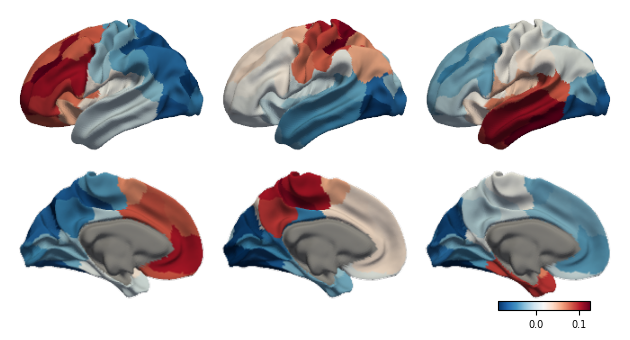

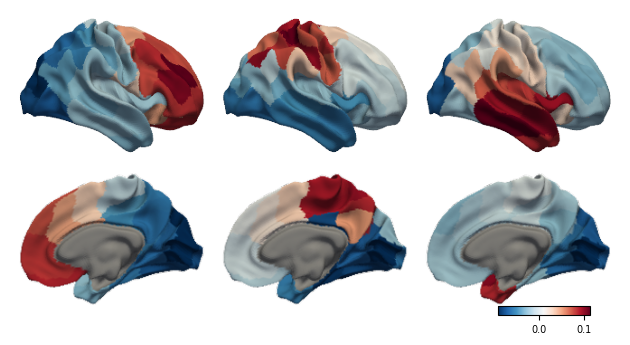

In [10]:
# Load atlas data
import brainspace.gradient.alignment as ga
atlasDat = nib.load(atlas_path).get_fdata()[0].astype(int)

#save gms
gm_lh = GradientMaps(n_components=20, approach='dm')
gm_rh = GradientMaps(n_components=20, approach='dm')

n_pca = 3#number of gradients to plot

# Create gradient maps and plot for both hemispheres
for hemi, hcp_data, start_idx, end_idx, surf_file in [
    ('lh', lh_hcp_partialcorr, 0, 32492, 'S1200.L.white_MSMAll.32k_fs_LR.surf.gii'),
    ('rh', rh_hcp_partialcorr, 32492, None, 'S1200.R.white_MSMAll.32k_fs_LR.surf.gii')
]:
    # Create mask for non-zero atlas values
    mask = atlasDat[start_idx:end_idx] != 0

    # Create gradient maps
    if hemi == 'lh':
        gm = gm_lh.fit(np.nan_to_num(hcp_data, 0))
    else:
        gm =gm_rh.fit(np.nan_to_num(hcp_data, 0))
    
    
    grad = []
    for j in range(n_pca):
        if hemi == 'lh':
            grad_values = (gm.gradients_[:,j])
            grad.append(map_to_labels(grad_values, atlasDat[start_idx:end_idx], mask=mask, fill=np.nan))
        else:
            grad_values = gm.gradients_[:,j]
            grad.append(map_to_labels(grad_values, atlasDat[start_idx:end_idx], mask=mask, fill=np.nan))

    # Create plotters for first 3 gradients
    plotters = []
    for pc in range(n_pca):
        plotter = yaspy.Plotter(
            f'/Users/dennis.jungchildmind.org/Downloads/HCP_S1200_Atlas_Z4_pkXDZ/{surf_file}',
            hemi=hemi,
        )
        overlay = plotter.overlay(grad[pc], cmap='RdBu_r', alpha=1)
        plotter.border(grad[pc], alpha=0)
        plotters.append([plotter.screenshot("lateral"), plotter.screenshot("medial"), overlay])
    # Create lists for lateral and medial views
    lateral_views = [p[0] for p in plotters]
    medial_views = [p[1] for p in plotters]
    
    img = yaspy.montage(
        [lateral_views[:n_pca], 
         medial_views[:n_pca]],
        pad=10,
        shareh=True,
        sharew=True,  # Share width across subplots
    )
    # Create figure with controlled size
    f, ax = plt.subplots()
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.box(False)
    plt.tight_layout()

    cax = ax.inset_axes((0.8, 0, 0.15, 0.03))
    cbar = plt.colorbar(overlay, cax=cax, orientation="horizontal")
    cbar.ax.tick_params(labelsize="x-small")
    plt.show()

#then save gm_lh and gm_rh
np.save(f'gm_lh_hcp_n{N}_p{num_parcels}_norm{normalize_data}.npy', gm_lh)
np.save(f'gm_rh_hcp_n{N}_p{num_parcels}_norm{normalize_data}.npy', gm_rh)

/var/folders/71/4g31r9017kq32wt_mx1khjdm0000gn/T/ipykernel_94400/7641345.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


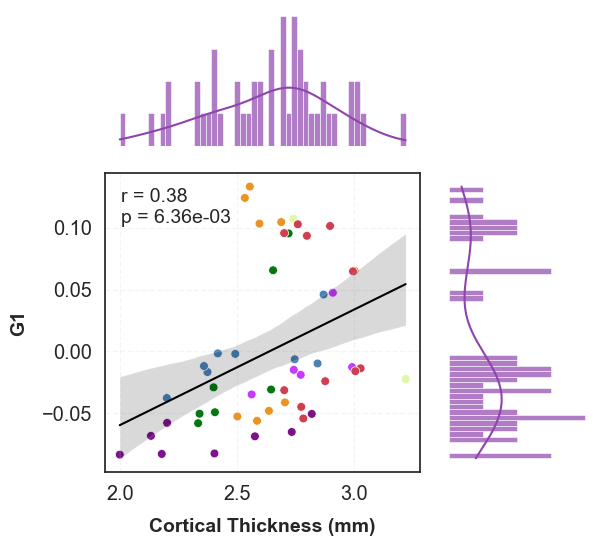

In [11]:
# Plot gradients vs thickness with histograms using seaborn for better aesthetics
import seaborn as sns
from scipy import stats

# Set the style with a cleaner look
sns.set_style("white")
sns.set_context("notebook", font_scale=1.3)

# Create figure for all three gradients
fig = plt.figure(figsize=(18, 6))

hemi = 'rh'

pc_idx = 0

for gradient_idx in range(1):
    if hemi == 'lh':
        data_x = np.mean(lh_hcp[1:,:],axis=1)
        data_y = gm_lh.gradients_[:,gradient_idx]
        data_label_color = yeo_network_colors[1:len(data_x)+1]
    else:
        data_x = np.mean(rh_hcp[1:,:],axis=1)
        data_y = gm_rh.gradients_[:,gradient_idx]
        data_label_color = yeo_network_colors[len(data_x)+1:]
    
    
    # Calculate correlation coefficient and p-value
    r, p = stats.pearsonr(data_x, data_y)
    
    the_color = ['#8E44AD', '#2ECC71', '#E74C3C'][gradient_idx]
    
    # Create subplot
    gs = fig.add_gridspec(3, 3, hspace=0.2, wspace=0.2, left=0.05+gradient_idx*0.32, right=0.32+gradient_idx*0.32)
    
    # Create the scatter plot with seaborn - enhanced aesthetics
    ax_scatter = fig.add_subplot(gs[1:, :-1])
    sns.scatterplot(x=data_x, y=data_y, alpha=1, s=40, color=data_label_color,
                    edgecolor='white', linewidth=0.5, ax=ax_scatter, 
                     legend='brief')
    
    # Add regression line
    sns.regplot(x=data_x, y=data_y, scatter=False, color='black', 
                line_kws={'linestyle': '-', 'linewidth': 1.5}, ax=ax_scatter)
    
    # Add correlation coefficient text
    ax_scatter.text(0.05, 0.95, f'r = {r:.2f}\np = {p:.2e}', 
                    transform=ax_scatter.transAxes, 
                    verticalalignment='top',
                    fontsize=14)
    
    ax_scatter.set_xlabel('Cortical Thickness (mm)', fontsize=14, labelpad=10, weight='bold')
    ax_scatter.set_ylabel(f'G{gradient_idx+1}', fontsize=14, labelpad=10, weight='bold')
    
    # Add subtle grid only to the scatter plot
    ax_scatter.grid(True, linestyle='--', alpha=0.2)
    
    # Create the x-axis histogram with KDE - enhanced aesthetics
    ax_histx = fig.add_subplot(gs[0, :-1])
    sns.histplot(data=data_x, bins=50, kde=True, color=the_color, 
                 ax=ax_histx, stat='density', alpha=0.7)
    ax_histx.set_xlabel('')
    ax_histx.set_ylabel('')
    ax_histx.set_yticks([])
    ax_histx.tick_params(labelbottom=False)
    ax_histx.spines['top'].set_visible(False)
    ax_histx.spines['right'].set_visible(False)
    ax_histx.spines['bottom'].set_visible(False)
    ax_histx.spines['left'].set_visible(False)
    
    # Create the y-axis histogram with KDE - enhanced aesthetics
    ax_histy = fig.add_subplot(gs[1:, -1])
    data_rotated = np.flip(data_y)
    sns.histplot(y=data_rotated, bins=50, kde=True, color=the_color, 
                 ax=ax_histy, stat='density', alpha=0.7)
    ax_histy.set_xlabel('')
    ax_histy.set_ylabel('')
    ax_histy.set_xticks([])
    ax_histy.tick_params(labelleft=False)
    ax_histy.spines['top'].set_visible(False)
    ax_histy.spines['right'].set_visible(False)
    ax_histy.spines['bottom'].set_visible(False)
    ax_histy.spines['left'].set_visible(False)
    
    # Remove grid from histograms
    ax_histx.grid(False)
    ax_histy.grid(False)

# Adjust layout
plt.tight_layout()


In [ ]:
print(len(yeo_network_names))

In [ ]:
# Load atlas data
atlasDat = nib.load(atlas_path).get_fdata()[0].astype(int)

# Create gradient maps and plot for both hemispheres
for hemi, hcp_data, start_idx, end_idx, surf_file in [
    ('lh', lh_hcp_partialcorr, 0, 32492, 'S1200.L.white_MSMAll.32k_fs_LR.surf.gii'),
    ('rh', rh_hcp_partialcorr, 32492, None, 'S1200.R.white_MSMAll.32k_fs_LR.surf.gii')
]:
    # Create mask for non-zero atlas values
    mask = atlasDat[start_idx:end_idx] != 0

    # Create gradient maps

    grad = []
    for j in range(1):
        if hemi == 'lh':
            grad_values = np.arange(1,51) # Yes, this creates array from 1 to 50 since arange(start,stop) excludes stop value

            grad.append(map_to_labels(grad_values, atlasDat[start_idx:end_idx], mask=mask))


        else:
            grad_values = np.arange(1,51)
            grad.append(map_to_labels(grad_values, atlasDat[start_idx:end_idx], mask=mask))

    # Create plotters for first 3 gradients
    plotters = []
    for pc in range(1):
        plotter = yaspy.Plotter(
            f'/Users/dennis.jungchildmind.org/Downloads/HCP_S1200_Atlas_Z4_pkXDZ/{surf_file}',
            hemi=hemi,
        )
        #create colormap based on  yeo_network_colors[1:len(data_x)+1]
        print(np.unique(grad[pc]))
        # Create a custom colormap from the yeo network colors
        uniq_grad_len = len(np.unique(grad[pc]));
        from matplotlib.colors import ListedColormap
        custom_labels = yeo_network_names[0:uniq_grad_len]
        if hemi == 'lh':
            custom_cmap = ListedColormap(yeo_network_colors[0:uniq_grad_len])
            
        else:
            custom_cmap = ListedColormap([yeo_network_colors[0]] + list(yeo_network_colors[uniq_grad_len:]))
           # custom_labels = yeo_network_names[0:uniq_grad_len]

        overlay = plotter.overlay(grad[pc], cmap=custom_cmap, alpha=1)# vmin=1.5, vmax=3.5)
        plotter.border(grad[pc], alpha=0)
        plotters.append([plotter.screenshot("lateral"), plotter.screenshot("medial"), overlay])

    img = yaspy.montage(
        [[plotters[0][0]],
         [plotters[0][1]]],
        pad=10,
        shareh=True,
        sharew=True,  # Share width across subplots
    )
        
    # Create figure with controlled size
    f, ax = plt.subplots()
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.box(False)
    plt.tight_layout()
    cax = ax.inset_axes((1, 0.2, 0.05, 0.6))  # Moved to right side
    cbar = plt.colorbar(overlay, cax=cax, orientation="vertical")  # Changed to vertical
    cbar.ax.tick_params(labelsize="x-small")
    # Set the tick locations and labels using custom_labels
    unique_labels = []
    unique_ticks = []
    seen_labels = set()
    #count how many unique labels there are for each label 

    for i, label in enumerate(custom_labels):
        
        if label not in seen_labels and i > 0:  # Skip first value
            #chceck how many times the label appears in custom_labels
            label_count = custom_labels.count(label)
            print(label_count)
            unique_labels.append(label)
            unique_ticks.append(i+np.ceil(label_count/2)-1)  # Changed from i + 0.5 to i to center in middle of colors
            seen_labels.add(label)
    cbar.set_ticks(unique_ticks)  # Only use ticks for unique labels
    cbar.set_ticklabels(unique_labels, rotation=0, fontsize=12, weight='bold')  # Increased font size and made bold
    plt.show()